```
Caleb Mburu
Midterm: MongoDB Notebooks

For this assignment, I will create a new Jupyter notebook.  I will then retrieve 2017 movie data from MongoDB, from both the IMDB and Metacritic data collections.  I will then merge the two data sets together using Pandas Merge.  I will add a machine learning analysis column to the dataset.  Finally, I will display a chart that demonstrates the results using the machine learning analysis column, and add a conclusion to explain what I have learned.
```

In [1]:
import json

# Demonstration of how to load a file that contains secrets without accidentally leaking those secrets
with open("C:\\Users\\Owner\\OneDrive\\Documents\\Automate Boring Stuff\\secrets.json") as f:
    data = json.load(f)

    # If you want your data to be secure, don't print this variable out!
    # Juputer will retain a cached version of any printed data and it can be
    # accidentally committed to version control.
    secret_key = data["mongodb"]

In [2]:
import pandas
import re
import pymongo
import certifi

# Connect to the database and verify it's working. This prints lots of stuff!
client = pymongo.MongoClient(secret_key, tlsCAFile=certifi.where())
db = client.Database1
all_collections = db.list_collection_names()
print(all_collections)

# Find data from IMDB for one particular year using my transformed pipeline view
imdb_view = pandas.DataFrame(db.IMDB_Pipeline_View.find({'year': 2007}))

# Find data from Metacritic for the same year
metacritic_view = pandas.DataFrame(db.Metacritic.find({'release_date': re.compile('2007') }))

# The metacritic view isn't transformed - let's convert values to numbers
metacritic_view.score = pandas.to_numeric(metacritic_view.score, errors='coerce')
metacritic_view.release_date = pandas.to_datetime(metacritic_view.release_date, errors='coerce')

['IMDB Fixed', 'IMDB', 'Metacritic', 'IMDB_Pipeline_View']


In [3]:
# Merge the two datasets together using an inner join - should produce about 175 movies with data on both sides
unified_view = pandas.merge(imdb_view, metacritic_view, how='inner', on='title')
unified_view.head()

,_id_x,title,budget,is_budget_usd,genres,gross_sales,opening_weekend,runtime,user_rating,votes,...,opening_value,gross_digits,gross_value,mpaa,_id_y,movie_id,release_date_y,description,score,thumbnail
0,63715afa3bc31743d94b5d0f,Enchanted,"$85,000,000 (estimated)",True,"Animation, Adventure, Comedy, Family, Fantasy,...","$340,487,652","$34,440,317, 24 Nov 2007",107.0,7,200197,...,34440317.0,"{'match': '340,487,652', 'idx': 1, 'captures':...",340487652.0,PG,6714d99ba5f9477880811e65,14402,2007-11-21,A classic Disney fairy tale collides with mode...,75,https://static.metacritic.com/images/products/...
1,63715afd3bc31743d94b5d10,The Mist,"$18,000,000 (estimated)",True,"Horror, Sci-Fi, Thriller","$57,470,220","$8,931,973, 24 Nov 2007",126.0,7,312282,...,8931973.0,"{'match': '57,470,220', 'idx': 1, 'captures': ...",57470220.0,R,6714d99ba5f9477880811f20,14589,2007-11-21,David Drayton and his young son Billy are amon...,58,https://static.metacritic.com/images/products/...
2,63715aff3bc31743d94b5d11,No Country for Old Men,"$25,000,000 (estimated)",True,"Crime, Drama, Thriller","$171,627,166","$1,226,333, 11 Nov 2007",122.0,8,967552,...,1226333.0,"{'match': '171,627,166', 'idx': 1, 'captures':...",171627166.0,R,6714d99ba5f9477880811e2b,14344,2007-11-09,"The time is our own, when rustlers have given ...",92,https://static.metacritic.com/images/products/...
3,63715b023bc31743d94b5d12,Stardust,"$70,000,000 (estimated)",True,"Adventure, Family, Fantasy, Romance","$135,560,026, 14 Sep 2008",None,127.0,7,273320,...,NaN,"{'match': '135,560,026,', 'idx': 1, 'captures'...",135560026.0,PG-13,6714d99ba5f9477880811ecc,14505,2007-08-10,The enchanting tale of a fallen star who crash...,66,https://static.metacritic.com/images/products/...
4,63715b063bc31743d94b5d13,Harry Potter and the Order of the Phoenix,"$150,000,000 (estimated)",True,"Action, Adventure, Family, Fantasy, Mystery","$939,885,929",None,138.0,7,579409,...,NaN,"{'match': '939,885,929', 'idx': 1, 'captures':...",939885929.0,PG-13,6714d99ba5f9477880811e90,14445,2007-07-11,"In Harry Potter and the Order of the Phoenix, ...",71,https://static.metacritic.com/images/products/...


In [4]:
import statsmodels.formula.api as smf

# Now let's try to plot a linear relationship using all the numeric values we have at the same time.
ols_model = smf.ols(
    formula='gross_value ~ user_rating + budget_value + opening_value + votes + runtime',
    data=unified_view).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            gross_value   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     194.0
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.70e-42
Time:                        23:41:13   Log-Likelihood:                -1615.9
No. Observations:                  84   AIC:                             3244.
Df Residuals:                      78   BIC:                             3258.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.436e+07   5.13e+07     -0.474

```
The R-squared value is a guess of how successful this model is - the higher, the better

The P>[t] value is a measurement of how successful a variable is - the lower, the better

The warnings at the bottom of the page give us a clue - in our case, 'votes', 'opening weekend', and 'user ratings' overlap.
```

In [5]:
from transformers import pipeline

# Uses classification library published on https://huggingface.co/distilbert-base-uncased
classifier = pipeline('fill-mask', model='distilbert-base-uncased')
classifier('I would love to go to [MASK].')

[{'score': 0.038291122764348984,
  'token': 6014,
  'token_str': 'heaven',
  'sequence': 'i would love to go to heaven.'},
 {'score': 0.029044577851891518,
  'token': 25104,
  'token_str': 'disneyland',
  'sequence': 'i would love to go to disneyland.'},
 {'score': 0.022476231679320335,
  'token': 2793,
  'token_str': 'bed',
  'sequence': 'i would love to go to bed.'},
 {'score': 0.019097955897450447,
  'token': 3637,
  'token_str': 'sleep',
  'sequence': 'i would love to go to sleep.'},
 {'score': 0.014479922130703926,
  'token': 3290,
  'token_str': 'mexico',
  'sequence': 'i would love to go to mexico.'}]

In [6]:
import transformers

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = transformers.pipeline('sentiment-analysis', model=MODEL,
                                       tokenizer=transformers.AutoTokenizer.from_pretrained(MODEL))

# When I first executed this, it gave me a positive score of ~0.89
print(sentiment_task('Everything is going great in my life right now.'))

# This task gave a negative score of ~0.89
print(sentiment_task('I hate being stuck in traffic for hours.'))

# Neutral score of ~0.68
print(sentiment_task('I went to the store yesterday.'))

[{'label': 'positive', 'score': 0.8934980034828186}]
[{'label': 'negative', 'score': 0.8886245489120483}]
[{'label': 'neutral', 'score': 0.6846396923065186}]


In [7]:
# Create a function to turnn the sentiment analysis object into a single number
def calculate_sentiment(text):
    if text is None:
        return 0
    sentiment = sentiment_task(text)
    if sentiment[0]['label'] == 'negative':
        return 0 - sentiment[0]['score'] - 0.5
    elif sentiment[0]['label'] == 'neutral':
        return sentiment[0]['score'] - 0.5
    elif sentiment[0]['label'] == 'positive':
        return 1 + sentiment[0]['score'] - 0.5

# Test this function
print(calculate_sentiment('This has been the worst day ever.'))
print(calculate_sentiment('The weather is perfect today.'))
print(calculate_sentiment('I have a meeting at 3 PM'))
print(calculate_sentiment(None))

-1.4448429942131042
1.4211589694023132
0.31437110900878906
0


```
- Positive number will start at 0.5 and go up to 1.5
- Neutral numbers will start at -0.5 and go to 0.5
- Negative numbers will go from -0.5 to -1.5
```

In [8]:
# First, we will apply a lambda to calculate sentiment for the movies in the dataset
# We use "row.get('description')" instead of "row['description']" because it returns None if there is no description.
sentiment_column = unified_view.apply(lambda row: calculate_sentiment(row.get('description')), axis = 1)

# Next add this column back into the unified view 
# Assigning it via an array indexer allows us to re-run this code block multiple times and replace the sentiment column
# so we can tinker with it and update the calculations
unified_view['sentiment'] = sentiment_column

# Debuging! Let's see what we have
unified_view.head()

,_id_x,title,budget,is_budget_usd,genres,gross_sales,opening_weekend,runtime,user_rating,votes,...,gross_digits,gross_value,mpaa,_id_y,movie_id,release_date_y,description,score,thumbnail,sentiment
0,63715afa3bc31743d94b5d0f,Enchanted,"$85,000,000 (estimated)",True,"Animation, Adventure, Comedy, Family, Fantasy,...","$340,487,652","$34,440,317, 24 Nov 2007",107.0,7,200197,...,"{'match': '340,487,652', 'idx': 1, 'captures':...",340487652.0,PG,6714d99ba5f9477880811e65,14402,2007-11-21,A classic Disney fairy tale collides with mode...,75,https://static.metacritic.com/images/products/...,-0.085134
1,63715afd3bc31743d94b5d10,The Mist,"$18,000,000 (estimated)",True,"Horror, Sci-Fi, Thriller","$57,470,220","$8,931,973, 24 Nov 2007",126.0,7,312282,...,"{'match': '57,470,220', 'idx': 1, 'captures': ...",57470220.0,R,6714d99ba5f9477880811f20,14589,2007-11-21,David Drayton and his young son Billy are amon...,58,https://static.metacritic.com/images/products/...,-1.135587
2,63715aff3bc31743d94b5d11,No Country for Old Men,"$25,000,000 (estimated)",True,"Crime, Drama, Thriller","$171,627,166","$1,226,333, 11 Nov 2007",122.0,8,967552,...,"{'match': '171,627,166', 'idx': 1, 'captures':...",171627166.0,R,6714d99ba5f9477880811e2b,14344,2007-11-09,"The time is our own, when rustlers have given ...",92,https://static.metacritic.com/images/products/...,-1.084912
3,63715b023bc31743d94b5d12,Stardust,"$70,000,000 (estimated)",True,"Adventure, Family, Fantasy, Romance","$135,560,026, 14 Sep 2008",None,127.0,7,273320,...,"{'match': '135,560,026,', 'idx': 1, 'captures'...",135560026.0,PG-13,6714d99ba5f9477880811ecc,14505,2007-08-10,The enchanting tale of a fallen star who crash...,66,https://static.metacritic.com/images/products/...,-0.891267
4,63715b063bc31743d94b5d13,Harry Potter and the Order of the Phoenix,"$150,000,000 (estimated)",True,"Action, Adventure, Family, Fantasy, Mystery","$939,885,929",None,138.0,7,579409,...,"{'match': '939,885,929', 'idx': 1, 'captures':...",939885929.0,PG-13,6714d99ba5f9477880811e90,14445,2007-07-11,"In Harry Potter and the Order of the Phoenix, ...",71,https://static.metacritic.com/images/products/...,-1.051694


In [9]:
# Allows me to see all the columns in the dataset
print(unified_view.columns)

Index(['_id_x', 'title', 'budget', 'is_budget_usd', 'genres', 'gross_sales',
       'opening_weekend', 'runtime', 'user_rating', 'votes', 'certification',
       'release_date_x', 'release_date_fixed', 'year', 'month', 'day',
       'certlist', 'budget_digits', 'budget_value', 'opening_digits',
       'opening_value', 'gross_digits', 'gross_value', 'mpaa', '_id_y',
       'movie_id', 'release_date_y', 'description', 'score', 'thumbnail',
       'sentiment'],
      dtype='object')


In [10]:
# A custom formatter for currency
from numbers import Number

def format_currency(amount: Number, _):
    if amount > 1_000_000_000_000:
        return f"${round(amount / 1_000_000_000_000)}T"
    elif amount > 1_000_000_000:
        return f"${round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"${round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"${round(amount / 1_000)}K"
    else:
        return f"${round(amount)}"


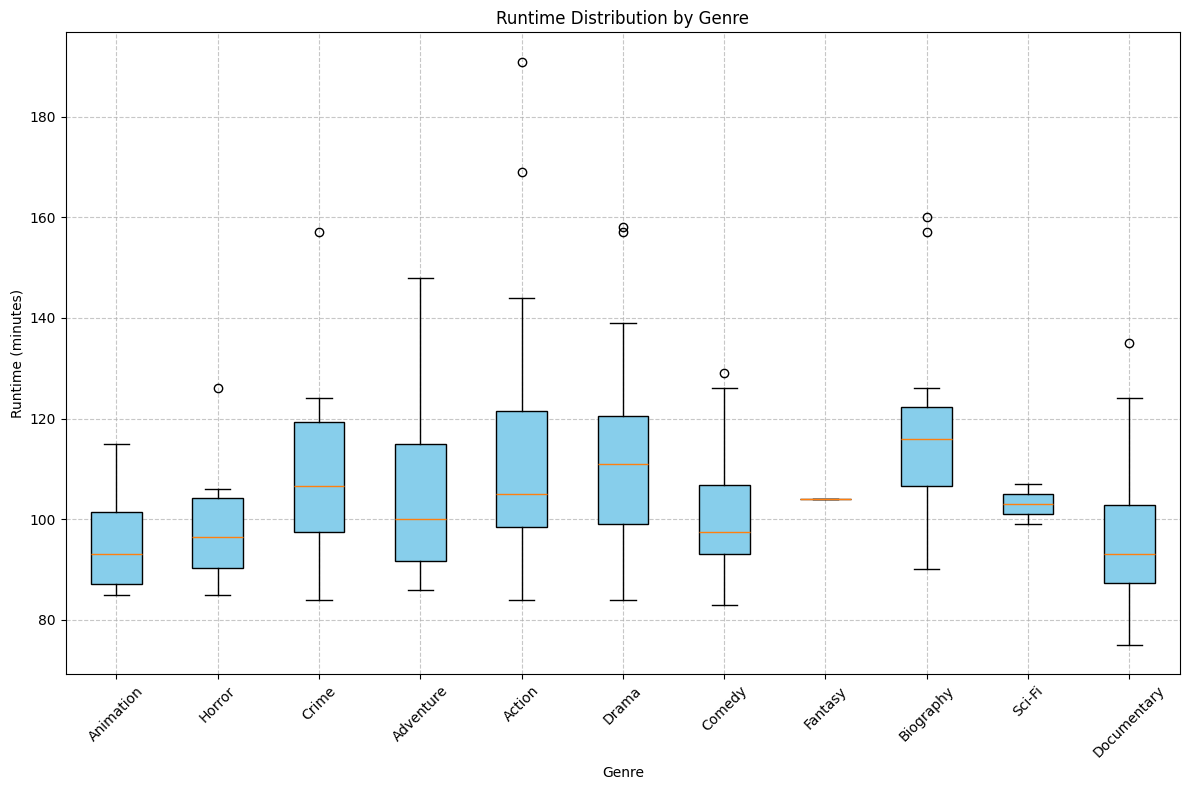

In [11]:
import matplotlib.pyplot as plt

# Extract the first genre for each movie
unified_view['primary_genre'] = unified_view['genres'].apply(lambda x: x.split(',')[0])

plt.figure(figsize=(12, 8))
boxplot = plt.boxplot([unified_view[unified_view['primary_genre'] == genre]['runtime'] for genre in unified_view['primary_genre'].unique()], 
            patch_artist=True)

# Change the color of the boxes to sky blue
for patch in boxplot['boxes']:
    patch.set_facecolor('skyblue')
 
# Set the plot title and axis labels
plt.xticks(range(1, len(unified_view['primary_genre'].unique()) + 1), unified_view['primary_genre'].unique(), rotation=45)
plt.xlabel('Genre')
plt.ylabel('Runtime (minutes)')
plt.title('Runtime Distribution by Genre')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


```
The box plot shows the runtime distribution of movies across different genres in 2017, highlighting variations in typical movie lengths. Genres like Animation and Horror have shorter median runtimes, whereas Biography movies tend to be longer. Genres like Sci-Fi and Fantasy show tight runtime distributions, indicating consistency in their movie lengths, while genres like Drama and Adventure have more variability. Outliers especially in Adventure, Drama, and Documentary, represent unusually long runtimes for those genres.
```

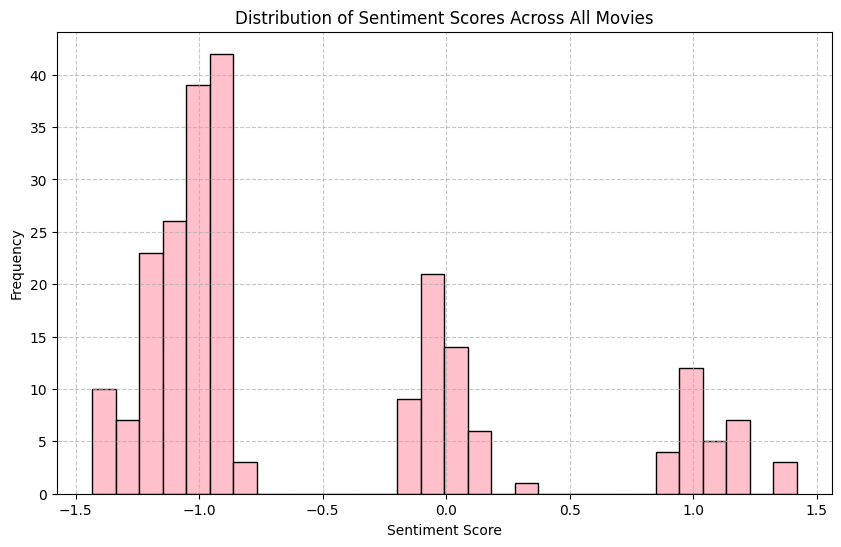

In [12]:
import matplotlib.pyplot as plt

# Create the histogram to show the distribution of sentiment scores across all movies
plt.figure(figsize=(10, 6))
plt.hist(unified_view['sentiment'], bins=30, color='pink', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores Across All Movies')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


```
This histogram shows the distribution of sentiment scores for a collection of movies. The scores are spread across three main peaks, representing clusters of negative, neutral, and positive sentiments. The largest cluster is around -1.0, showing a high frequency of negative sentiment scores. There is also a smaller peak near 0, representing neutral sentiment, and a third peak around 1.0, indicating some positive sentiment scores. Overall, the distribution suggests that most movies have negative sentiment, with less movies scoring neutral or positive sentiments.
```

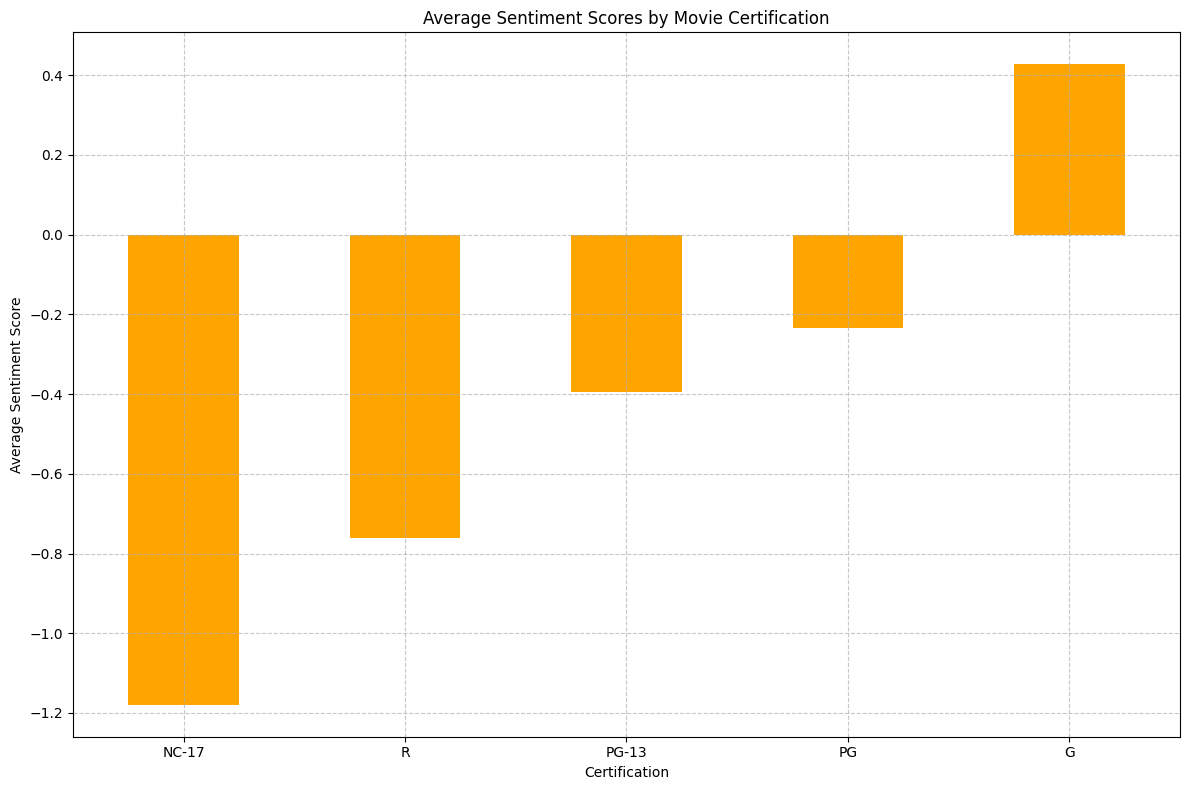

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average sentiment scores for each certification
average_sentiment_by_certification = unified_view.groupby('mpaa')['sentiment'].mean().sort_values()

# Create a bar chart to compare the average sentiment scores across different movie certifications
plt.figure(figsize=(12, 8))
average_sentiment_by_certification.plot(kind='bar', color='orange')
plt.xticks(rotation=0) 
plt.xlabel('Certification')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Scores by Movie Certification')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

```
This bar chart shows the average sentiment scores for movies based on their certification rating. **NC-17** and **R-rated** movies have the lowest average sentiment scores, indicating a tendency toward negative sentiment in these categories. **PG-13** and **PG** movies also have negative average scores, but to a lesser extent. **G-rated** movies, on the other hand, have the highest average sentiment score, indicating a generally positive sentiment. Overall, movies with more restrictive certifications (like NC-17 and R) are associated with negative sentiment, while movies with more family-friendly ratings (like G) lean towards positive sentiment.
```